In [ ]:
%%HTML
<!-- Make fonts readable at 1024x768 -->
<style>
.rendered_html { font-size:0.5em; }
</style>

In [14]:
# Imports and matplotlib configuration
import numpy as np
import scipy.signal
from scipy import fftpack
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import animation, rcParams, patches
from ipywidgets import interact, FloatSlider, IntSlider, SelectionSlider, Layout, Button, Output, Box
from IPython.display import display, Audio, HTML
import soundfile as sf

# Default options for matplotlib plots
rcParams['figure.dpi'] = 80
rcParams['font.size'] = 14
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['legend.framealpha'] = 0.5
rcParams['legend.fontsize'] = 'medium'
rcParams['figure.titlesize'] = 'medium'
rcParams['figure.autolayout'] = True
# rcParams['animation.html'] = 'html5'
slider_layout = Layout(width='500px', height='20px')
slider_style = {'description_width': 'initial'}
from functools import partial
FloatSlider_nice = partial(FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
IntSlider_nice = partial(IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelectionSlider_nice = partial(SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

# Optional: Set options for slide theme and transition
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/phuijse/.jupyter/nbconfig/"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
    'theme': 'simple',
    'transition': 'fast',
    'start_slideshow_at': 'selected',
    'width': 1024,
    'height': 768,
    'scroll': True,
    'center': False
});

### Universidad Austral de Chile 
## INFO183: Análisis de sistemas lineales


# Unidad 2: Herramientas de análisis de señales

### Dr. Pablo Huijse, phuijse at inf dot uach dot cl 

### <a href="https://github.com/phuijse/UACH-INFO183"> github.com/phuijse/UACH-INFO183 </a>


***
<a id="index"></a>

# Contenidos de la unidad

***

1. [Representación por serie de Fourier](#section1)
1. [Transformada de Fourier](#section2)
1. [Principio de incertidumbre](#section3)
1. [Transformada de Fourier discreta (DFT) y sus propiedades](#section4)
1. [Efectos del muestreo y del enventanado](#section5)
1. [Transformada rápida de Fourier (FFT)](#section6)
1. [Espectrograma con Transformada de Fourier de tiempo reducido](#section7)
1. Detección y comparación de señales
1. Autocorrelación y correlación cruzada
1. Espectro de potencia y periodograma
1. Teorema de Wiener-Khinchin
1. Detección de señales con Match filter
1. Limpieza de señales con filtro de Wiener


***

# Espectro

***

- Isaac Newton llamó **espectros** a los componentes que forman la luz blanca y que normalmente no se pueden ver
- Newton mostró usando prismas que la luz blanca pueden descomponerse en colores y viceverza
- Hoy entendemos que la luz como onda tiene una frecuencia asociada y que cada color es una frecuencia particular


| <img src="img/fourier-newton.jpg">  | <img src="img/fourier-prism.jpg" width="75%">  |
|:-:|:-:|

- Paradojicamente, Newton nunca acepto que esto se debía a la frecuencia de la radiación ya que creía en la teoría corpuscular de la luz


## Onda

- Es una perturbación que transporta energía a través del espacio
- Es una oscilación o vibración de un medio físico o campo
- Se describe (tipicamente) por su frecuencia (período), amplitud y desfase

**Onda electromagnética** 
- Oscilaciones en el campo eléctrico y magnético
- Transporta energía electromágnetica radiativa
- Dependiendo de su frecuencia se clasifican como:
<img src="img/fourier-colors.jpg">

## Componentes frecuenciales y harmónicos

- Una sinusoide es una función del tiempo completamente descrita por su amplitud $A$, frecuencia $f$ y fase $\phi$

$$
s(t) = A \cos (2 \pi f t + \phi)
$$

*Ejercicio:* Explique intuitivamente como estos parámetros afectan a $s(t)$ 

- El recíproco de la frecuencia es el período $P= \frac{1}{f}$
- Notemos que una señal que es períodica en $\frac{P}{k} ~ \forall k \in \mathbb{N}$ también lo es en $P$
- Llamamos a $f_0 = 1/P$ la **frecuencia fundamental**
- Llamamos a $f_k = kf_0 = k/P ~~ \forall k \in \mathbb{N}$ el **k-esimo armónico de $f_0$**

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 3))
f = 1.51518
t = np.linspace(0, 2/f, num=500); x = np.cos(2.0*np.pi*f*t)
ax.plot(t, x, label='fundamental')
line = ax.plot(t, x, label='k-th harmonic'); ax.legend(loc=4)
ax.set_xticks([0, 1/f, 2/f]); ax.set_xticklabels(["0", r"$1/f_0$", r"$2/f_0$"]);
update = lambda k: line[0].set_ydata(np.cos(2.0*np.pi*t*f*k))
interact(update, k=SelectionSlider_nice(options=[2, 3, 4, 5, 6]));

- Si sumamos dos sinusoides con amplitudes arbitrarias pero con igual frecuencia fundamental $f_0$ [Hz], la suma también es periódica con fundamental $f_0$ [Hz]
- La suma puede ser una señal periódica arbitraria (no trigonométrica)

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 3))
f = 1.51518
t = np.linspace(0, 3/f, num=500); x = np.cos(2.0*np.pi*f*t)
line = ax.plot(t, 2*x)
ax.set_xticks([0, 1/f, 2/f, 3/f]); ax.set_xticklabels(["0", r"$1/f_0$", r"$2/f_0$", r"$3/f_0$"]);
ax.set_title(r"$\cos(2\pi t f_0) + A \sin(2\pi t k f_0)$")
update = lambda k, A: line[0].set_ydata(x + A*np.sin(2.0*np.pi*t*f*k))
interact(update, k=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 6]), 
         A=FloatSlider_nice(min=0.5, max=1.0, value=0.5));

- Dependiendo de los armónicos que incorporemos podemos reproducir distintas señales periódicas

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f = 1.51518; t = np.linspace(-2/f, 2/f, num=5000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([-2/f, -1/f, 0, 1/f, 2/f]); 
ax.set_xticklabels([r"$-2/f_0$", r"$-1/f_0$", "0", r"$1/f_0$", r"$2/f_0$"]);
ax.set_title(r"$s_K(t) =  \frac{1}{2} + \sum_{k=1}^K \frac{\sin(\pi k/2)}{\pi k/2} \cos(2\pi k f_0 t ) $")
def update(K):
    y = np.zeros_like(t) + 0.5
    for k in range(1, K+1):
        y += 2*np.sin(np.pi*k/2)*np.cos(2.0*np.pi*k*f*t)/(np.pi*k)
    line[0].set_ydata(y); ax.set_ylim([-0.2, 1.2])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f = 1.51518; t = np.linspace(-2/f, 2/f, num=5000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([-2/f, -1/f, 0, 1/f, 2/f]); 
ax.set_xticklabels([r"$-2/f_0$", r"$-1/f_0$", "0", r"$1/f_0$", r"$2/f_0$"]);
ax.set_title(r"$s_K(t) = \sum_{k=1}^K \frac{1}{k} \sin(2\pi k f_0 t) $")
def update(K):
    y = np.zeros_like(t)
    for k in range(1, K+1):
        y += np.sin(2.0*np.pi*k*f*t)/k
    line[0].set_ydata(y); ax.set_ylim([np.amin(y)*1.1, np.amax(y)*1.1])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

- Las funciones coseno y seno son par e impar, respectivamente
- ¿Cómo podemos construir una señal periódica que no es par ni impar?
- Consideremos la siguiente forma general
$$
\begin{align}
s(t) &= \sum_{k=0}^\infty A_k \cos(2\pi k f t + \phi_k) \nonumber \\
&= \sum_{k=0}^\infty a_k \cos(2\pi k f t) + b_k \sin(2\pi k f t), \nonumber
\end{align}
$$
donde $a_k = A_k \cos(\phi_k)$ y $b_k = -A_k \sin(\phi_k)$ se obtienen de $\cos(x+y) = \cos(x)\cos(y) - \sin(x)\sin(y)$
- De esta forma $s(t)$ puede ser cualquier función real periódica con período $P=1/f$
- Esto se conoce como **serie trigonométrica** 

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f = 1.51518; t = np.linspace(-2/f, 2/f, num=5000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([-2/f, -1/f, 0, 1/f, 2/f]); 
ax.set_xticklabels([r"$-2/f_0$", r"$-1/f_0$", "0", r"$1/f_0$", r"$2/f_0$"]);
def update(K):
    y = np.zeros_like(t)
    for k in range(1, K+1):
        y += np.cos(2.0*np.pi*k*f*t)/k + (-1)**k*np.sin(2.0*np.pi*(2*k-1)*f*t)/(2*k-1)
    line[0].set_ydata(y); ax.set_ylim([np.amin(y)*1.1, np.amax(y)*1.1])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

### Apéndice: Números complejos

Sea z un número complejo, lo podemos escribir en forma cartesiana 
$$
z = \Re[z] + j \Im[z] = a + j b
$$
donde $a \in \mathbb{R}$, $b \in \mathbb{R}$ y $j = \sqrt{-1}$ es el número imaginario.


También podemos escribirlo en forma polar
$$
z = c e^{j\phi} = c \cos(\phi) + j c \sin(\phi)
$$
donde 
- $c = |z| = \sqrt{a^2 + b^2} \in [0, \infty]$ es la magnitud 
- $\phi = \angle z = \tan^{-1} \left (\frac{b}{a} \right) \in [-\frac{\pi}{2}, \frac{\pi}{2}]$ es el ángulo
- $a = c \cos(\phi)$
- $b = c\sin(\phi)$

se pueden escribir las siguientes relaciones 

$$
\cos(\phi) = \frac{1}{2} (e^{j\phi} + e^{-j\phi}) ~\wedge~ \sin(\phi) = \frac{1}{2j} (e^{j\phi} - e^{-j\phi})
$$

el complejo conjugado de $z = a + j b = c e^{j\phi}$ es
$$
z^* = a - jb = c e^{-j\phi}
$$

In [ ]:
from matplotlib import patches
plt.close('all'); fig, ax = plt.subplots(figsize=(4, 4))
my_arrow = partial(ax.arrow, x=0, y=0, width=0.02, length_includes_head=True, linewidth=0)
my_arrow(dx=np.sqrt(0.5), dy=np.sqrt(0.5)); my_arrow(dx=1, dy=0); my_arrow(dx=0, dy=1)
ax.text(x=-0.2, y=1.0, s="Imag", fontsize=30); ax.text(x=1.0, y=-0.0, s="Re", fontsize=30);
ax.text(x=-0.15, y=np.sqrt(0.5), s="b", fontsize=30); ax.text(x=np.sqrt(0.5), y=-.15, s="a", fontsize=30);
ax.text(x=0.2, y=0.5, s="$|z|$", fontsize=30, rotation=45.); ax.text(x=0.3, y=0.1, s="$\phi$", fontsize=30);
ax.plot([0, np.sqrt(0.5)], [np.sqrt(0.5), np.sqrt(0.5)],'k--');
ax.plot([np.sqrt(0.5), np.sqrt(0.5)], [0, np.sqrt(0.5)],'k--')
p = patches.Circle(xy=(0, 0), radius=1, alpha=0.1); ax.set_xticks([]); ax.set_yticks([])
ax.scatter([0, np.sqrt(0.5)], [np.sqrt(0.5), 0], c='k', s=200);
ax.add_artist(p); plt.xlim([-0.25 , 1.25]); plt.ylim([-0.2 , 1.2]);

***
<a id="section1"></a>
[Volver al índice](#index)

# Serie de Fourier
***

- En 1807 *Jean Baptiste Joseph Fourier* presenta un teorema indicando que una función periódica arbitraria con periódo $P=1/f_0$ puede representarse como una suma ponderada de senos y cosenos
- La serie de Fourier (FS) para una función compleja se define como
$$
s(t) = \sum_{k=-\infty}^{\infty} c_k e^{j 2\pi k f_0 t}, ~~ c_k \in \mathbb{C}
$$

***

**Notemos que: ** La serie trigonométrica es el caso particular de la FS para una función real
$$
\begin{align}
s(t) &= \sum_{k=-\infty}^{\infty} c_k e^{j 2\pi kf_0 t} \nonumber \\
&= \sum_{k=1}^{\infty} c_{-k} e^{-j 2\pi kf_0 t} + c_0 + \sum_{k=1}^{\infty} c_{k} e^{j 2\pi kf_0 t} \nonumber\\
&= \sum_{k=1}^{\infty} \left(c_{k} e^{j 2\pi kf_0 t}\right)^* + c_0 + \sum_{k=1}^{\infty} c_{k} e^{j 2\pi kf_0 t} \nonumber\\
&= c_0 + 2 \sum_{k=1}^{\infty} \Re [ c_{k} e^{j 2\pi kf_0 t} ]\nonumber\\
&= \sum_{k=0}^{\infty} A_k \cos({j 2\pi kf_0 t + \phi_k} ), \nonumber
\end{align}
$$
donde en la última equivalencia reconocemos
$$
c_k = \begin{cases}  \frac{1}{2} A_k e^{j\phi_k} & k> 0 \\ A_0 & k = 0 \\ c_{|k|}* & k < 0\end{cases}
$$

***

### Apéndice: Bases generadoras
 - Una base es un conjunto de un espacio vectorial
 - Los elementos de la base son linealmente independientes
 - Todos los elementos del espacio pueden expresarse como una combinación lineal de la base
 
Considere el espacio vectorial $\mathbb{R}^3$. El siguiente conjunto 

$$
\left \{ v_1=\begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}, v_2= \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}, v_3=\begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}\right \},
$$

es una base generadora de $\mathbb{R}^3$, es decir un vector cualquiera $\vec a = (a_1, a_2, a_3) \in \mathbb{R}^3$ se puede representar como 

$$
\vec a = a_1 v_1 + a_2 v_2 + a_3 v_3.
$$

Un conjunto ortonormal siempre es linealmente independiente
***

***

## Base de Fourier

El conjunto de funciones 

$$
v_k (t) = \frac{1}{\sqrt{P}} e^{j2\pi k t / P} ~~ \forall k \in \mathbb{Z}
$$

cumple 

$$
\langle v_n (t), v_m (t) \rangle = \int_0^P v_n (t) v_m^* (t) dt = \frac{1}{P} \int_0^P e^{j2\pi (n-m)t/P} dt =\begin{cases}1 & n=m \\ 0 & n \neq m\end{cases}
$$

*i.e.* es un conjunto ortonormal (l.i.) en el espacio de funciones periódicas con periódo $P$

Esto es facilmente comprobable si estudiamos

$$
\int_0^P e^{j2\pi k t / P} dt = \int_0^P \cos(2\pi k t/P) dt + j \int_0^P \sin(2\pi k t/P) dt 
$$

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 3))
dt=1e-4; P=1.1234; t = np.arange(0, P, step=dt);
line = ax.plot(t, np.zeros_like(t)); ax.set_ylim([-1.2, 1.2])
harmonic = lambda k: np.sin(2.0*np.pi*k*t/P)
def update(k):
    ax.cla(); ax.set_ylim([-1.2, 1.2])
    ax.plot(t, harmonic(k), 'k--')
    ax.fill_between(t, 0, harmonic(k), harmonic(k)>0, color='b', alpha=0.5)
    ax.fill_between(t, 0, harmonic(k), harmonic(k)<0, color='r', alpha=0.5)
    ax.set_title("$\int s dt$ = %e" %(np.sum(harmonic(k)*dt)))
interact(update, k=IntSlider_nice(min=0, max=10, value=1));

propiedad generadora?

***
### Síntesis

$$
s(t) = \sum_{k=-\infty}^{\infty} c_k e^{j 2\pi k t/P} 
$$

***

***
### Análisis

\begin{align}
\langle s(t),  e^{j 2\pi m t/ P} \rangle &= \int_0^P s(t) e^{-j 2\pi m t/ P} dt \nonumber \\
&= \int_0^P \sum_{k=-\infty}^{\infty} c_k e^{j 2\pi k t/P} e^{-j 2\pi m t/P} dt \nonumber \\
&= \sum_{k=-\infty}^{\infty} c_k  \int_0^P e^{j 2\pi (k-m) t/P}  dt \nonumber \\
&=  c_m  P \nonumber \\
\end{align}

Es decir los coeficientes de la FS se pueden encuentrar usando

$$
c_m = \frac{1}{P} \int_0^P s(t) e^{-j 2\pi m t/P} dt
$$
***

***

### Ejemplo: FS de señal cuadrada

Sea 
$$
s(t) = \begin{cases} 1 & t \in[0, \frac{P}{2}] \\ 0 & t \in [\frac{P}{2}, P] \end{cases}
$$
Los coeficientes de su FS son

$$
c_0 = \frac{1}{P} \int_0^P s(t) dt = \frac{1}{P} \int_0^{P/2} dt = \frac{1}{2}
$$
y
\begin{align}
c_k &= \frac{1}{P} \int_0^\frac{P}{2} e^{-j2\pi kt/P} dt  \\  
&= -\frac{j}{P}  \int_0^\frac{P}{2} \sin(2\pi kt/P) dt\\
&=  0 + j \frac{\cos(\pi k)  - 1}{2\pi k} \\
\end{align}

Notemos que los coeficientes 
- A excepsión de $c_0$ sólo tienen parte imaginaria
- sólo son distintos de cero para armónicos impares
- $c_k$ es una función impar

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
k = np.arange(-10, 10, step=1).astype('float')
ax.stem(k, (np.cos(np.pi*k)-1)/(2*np.pi*k+1e-10), basefmt=" ")
ax.set_xticks(range(-10, 10, 2)); ax.set_xlabel("k"); ax.set_ylabel("$\Im[c_k]$");

Finalmente la FS está dada por

\begin{align}
s(t) &= \sum_{k=-\infty}^{\infty} j \frac{\cos(\pi k)  - 1}{2\pi k}  e^{j 2\pi k t/P} \\
&= \frac{1}{2} + \sum_{k=1}^{\infty}  \frac{1 - \cos(\pi k)}{\pi k} \sin(2\pi k t/P) 
\end{align}

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f_0 = 1.51518; t = np.linspace(-2/f_0, 2/f_0, num=5000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([-2/f_0, -1/f_0, 0, 1/f_0, 2/f_0]); 
ax.set_xticklabels([r"$-2/f_0$", r"$-1/f_0$", "0", r"$1/f_0$", r"$2/f_0$"]);
def update(K):
    y = np.zeros_like(t) + 0.5
    for k in range(1, K+1):
        y += (1-np.cos(np.pi*k))*np.sin(2.0*np.pi*t*k*f_0)/(np.pi*k)
    line[0].set_ydata(y); ax.set_ylim([-0.2, 1.2])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

***

## Propiedades de la FS

- Si $s(t)$ es par entonces $c_k$ es par
- Si $s(t)$ es impar entonces $c_k$ es impar
- Si $s(t + P/2) = -s(t)$ (antiperiódica) entonces $c_k=0 $ para k par
- Si $s(t)$ es real y par entonces $c_k$ es real y par
- Si $s(t)$ es real e impar entonces $c_k$ es imaginario e impar
- La FS es lineal

***

### Teorema de Parseval

La potencia de una señal puede calcularse a partir de sus componentes

\begin{align}
P_s &= \frac{1}{P} \int_0^P |s(t)|^2 dt \nonumber \\
&= \frac{1}{P} \int_0^P |\sum_{k=-\infty}^{\infty} c_k e^{j 2\pi k t/P }|^2 dt \nonumber \\
&= \frac{1}{P} \int_0^P \sum_{k=-\infty}^{\infty} |c_k |^2 dt \nonumber \\
&= \sum_{k=-\infty}^\infty |c_k|^2 \nonumber
\end{align}
***

Visualización interactiva de la FS: https://bl.ocks.org/jinroh/7524988

***

## Convergencia de la serie de Fourier (Oppenheim, SS, Chap 3.4)

Para una serie periódica con periódo $P$, si
1. Es absolutamente integrable: $\int_0^P |s(t)| dt < \infty$
1. Tiene un número finito de extremos
1. Tiene un número finito de discontinuidades

entonces su FS converge para todo tiempo, excepto en las discontinuidades donde converge al punto medio.


- Estos tres puntos se conocen como **Condiciones de Dirichlet**
- **Fenomeno de Gibbs:** Una discontinuidad requiere ancho de banda infinito, *i.e.* no puede reproducirse con un número finito de términos (vea el ejemplo de la señal cuadrada)

***

***
<a id="section2"></a>
[Volver al índice](#index)

# Transformada de Fourier
***
- El concepto de frecuencia puede aplicarse también a señales no-periódicas
- **Joseph Fourier:** Una señal no-periódica puede ser vista como una señal periódica **con un período infinito**
- El único requisito es que ahora las frecuencias son un continuo, con un espaciado infinitesimal


Veremos que:
- Una señal analógica puede ser vista como continua en el tiempo o continua en frecuencia
- Más adelante estudiaremos la Transformada de Fourier discreta (DFT) para señales digitales


***

Sea un tren de pulsos cuadrado con periódo P y ancho $2T < P$ definido en un período como

$$
s(t) = \begin{cases} 1, & |t| < T \\ 0, & T<|t| < P/2 \end{cases}
$$

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 3))

def create_square_pulse_train(t, T=0.25, P=2):
    s = np.zeros_like(t)
    for k in np.unique(t//P):
        s[(t> k*P - T) & (t< k*P + T)] = 1
    return s

t = np.linspace(-3, 3, num=300)
ax.plot(t, create_square_pulse_train(t), linewidth=4);

Su serie de Fourier es 
$$
c_0 = \frac{1}{P} \int_{-P/2}^{P/2} s(t) dt = \frac{1}{P} \int_{-T}^{T}  dt = \frac{2T}{P}
$$

\begin{align}
c_k &= \frac{1}{P} \int_{-T}^{T} e^{-j2\pi kt/P} dt  \\
&= \frac{1}{\pi k} \sin \left (2\pi k \frac{T}{P} \right) 
\end{align}

¿Qué ocurre a medida que P crece?


In [ ]:
plt.close('all'); fig, ax = plt.subplots(2, 1, figsize=(6, 6))

def update(P, show_envelope=False):
    ax[0].cla(); ax[1].cla(); T=0.25
    s = create_square_pulse_train(t, T=T, P=P)
    xhat = np.zeros_like(t) + 2*T/P
    ck = np.zeros(shape=(201, )); ck[100] = 2*T/P
    ck[101:] = np.array([np.sin(2.0*np.pi*k*T/P)/(np.pi*k) for k in range(1, 101)])
    ck[:100] = ck[101:][::-1]
    for k in range(1, 100):
        xhat += 2*np.cos(2.*np.pi*t*k/P)*ck[100+k]
    ax[0].plot(t, s, linewidth=4); ax[0].plot(t, xhat, linestyle='--', linewidth=4);
    f_axis = np.linspace(-100/P, 100/P, num=len(ck))
    ax[1].stem(f_axis, P*ck); 
    if show_envelope:
        ax[1].plot(f_axis, 2*T*np.sinc(2*f_axis*T), 'k-', linewidth=4, alpha=0.75);
interact(update, P=IntSlider_nice(min=1, max=15));

¿Qué ocurre con este ejemplo?

- A mayor P disminuye la frecuencia fundamental
- Cuando P es muy grande el tren de pulsos tiende a un único pulso
- A mayor P los coeficientes de la FS muestrean con más fineza **la envolvente**
- ¿A qué corresponde la envolvente en este caso?

***

***

Del ejemplo anterior notamos que la envolvente de la FS:
- Es una función de la frecuencia $f=kf_0 = k/P$
- Se obtiene cuando $P\to \infty$ y se define como
$$
S(f) = P c_k = \int_{-\infty}^{\infty} s(t) e^{-j 2\pi t  f} dt,
$$
o también
$$
S(\omega) = \int_{-\infty}^{\infty} s(t) e^{-j\omega t } dt,
$$
donde $\omega = 2\pi f$ se llama frecuencia angular.
- Se conoce como **transformada de Fourier directa** o **integral de Fourier**.

***

Reemplazando el resultado anterior en la ecuación de síntesis tenemos que
$$
\begin{align}
s(t) &= \lim_{f_0 \to 0} \sum_{k=-\infty}^{\infty} f_0 S(k f_0) e^{j 2\pi t  k f_0} \nonumber  \\
&= \int_{-\infty}^{\infty} S(f) e^{j 2\pi t  f} df \nonumber \\
&= \frac{1}{2\pi} \int_{-\infty}^{\infty} S(\omega) e^{j \omega t } d\omega, \nonumber 
\end{align}
$$
que se conoce como **transformada de Fourier inversa**.

***

***

## Par de Fourier

***

Directa:
$$
S(\omega) = \mathbb{FT}[s(t)] =  \int_{-\infty}^{\infty} s(t) e^{-j\omega t } dt,
$$

***

Inversa:
$$
s(t) =  \mathbb{FT}^{-1}[S(\omega)] = \frac{1}{2\pi} \int_{-\infty}^{\infty} S(\omega) e^{j \omega t } d\omega,
$$

***

***

### Ejemplo: Transformada de Fourier de pulso cuadrado

Sea
$$
s(t) = \begin{cases} 1, & |t| < T \\ 0, & |t| > T\end{cases}
$$

su transformada de Fourier es
$$
\begin{align}
S(\omega) &= \int_{-\infty}^{\infty} s(t) e^{-j\omega t } dt \\
&= \int_{-T}^{T} e^{-j\omega t } dt \\
&= \frac{1}{-j\omega} \left(e^{-j\omega T }  - e^{j\omega T } \right)\\
&= \frac{2}{\omega}  \sin(\omega T) = 2T \text{sinc}(\omega T)\\
\end{align}
$$

In [ ]:
plt.close('all'); fig, ax = plt.subplots(2, figsize=(6, 5))
t = np.linspace(-5, 5, num=500); 
f = np.linspace(-25, 25, num=500)
Fdict = np.cos(2.0*np.pi*t[:, np.newaxis]*f[:, np.newaxis].T)
ax[0].set_xlabel('Time [s]'); ax[1].set_xlabel('Frequency [Hz]');
line_square = ax[0].plot(t, np.zeros_like(t), linewidth=4); ax[0].set_ylim([-.1, 1.1])
line_sinc = ax[1].plot(f, np.zeros_like(f), linewidth=4, label='analytic')
line_FT = ax[1].plot(f, np.zeros_like(f), linewidth=4, linestyle='--', label='numeric')
ax[1].legend(loc=1)

def update(T):    
    s = np.zeros_like(t); s[(t> - T) & (t<  T)] = 1
    S =  np.sum(s*Fdict, axis=1)*0.02
    line_square[0].set_ydata(s); 
    line_sinc[0].set_ydata(2*T*np.sinc(2*f*T)); 
    line_FT[0].set_ydata(S); ax[1].set_ylim([np.amin(S)*1.2, np.amax(S)*1.2])

interact(update, T=SelectionSlider_nice(options=[1/16, 1/8, 1/4, 1/2, 1, 2]));

***

## Propiedades de la transformada de Fourier

Sea $S(\omega) = \mathbb{FT} [s(t)]$

- La FT es lineal
$$
\mathbb{FT}[c_1 s_1(t) + c_2 s_2(t)] = c_1\mathbb{FT}[s_1(t)] + c_2\mathbb{FT}[s_2(t)] 
$$
- Traslación
$$
\mathbb{FT}[s(t \pm \tau)] = e^{\pm j\omega \tau}\mathbb{FT}[s(t)] 
$$

- Escalamiento
$$
\mathbb{FT}[s(\beta t)] = \frac{1}{|\beta|} S \left( \frac{\omega}{\beta} \right)
$$

- Propiedad de diferenciación
$$
\mathbb{FT}\left[\frac{ds(t)}{dt}\right] = j \omega S(\omega)
$$
***
- La convolución en el tiempo es multiplicación en frecuencia 
$$
\mathbb{FT}[(s_1 * s_2)(t)] =  \mathbb{FT}[s_1(t)] \cdot \mathbb{FT}[s_2(t)],
$$
donde 
$$
(s_1 * s_2)(t) = \int s_1(\tau) s_2(t-\tau) d\tau
$$
es la operación de convolución
- y viceversa
$$
\mathbb{FT}[s_1(t)\cdot s_2(t)] =  \frac{1}{2\pi}\mathbb{FT}[s_1(t)] * \mathbb{FT}[s_2(t)]  
$$
***
- Dualidad
$$
\mathbb{FT}[S(t)] = 2\pi s(-\omega)
$$
***
- Teorema de Parseval
$$
\int | s(t) |^2 dt = \frac{1}{2\pi} \int | S(\omega) |^2 d\omega
$$
***

***

### Anexo: Operación de convolución

Convolución se define como:
$$
(s_1 * s_2)(t) = \int s_1(\tau) s_2(t-\tau) d\tau
$$

In [ ]:
plt.close('all'); fig, ax = plt.subplots(2, figsize=(7, 4))
t = np.arange(-4, 4, step=1e-2)

def square_pulse(t, a=0, T=1):
    s = np.zeros(shape=t.shape)
    s[np.absolute(t-a)<T] = 0.5 + 0.5*(t[np.absolute(t-a)<T]-a)/T 
    return s
lap_pulse = lambda t, a=0, s=1 : np.exp(-np.absolute(t-a)/s)
conv_s = np.convolve(square_pulse(t), lap_pulse(t), mode='same')

def update(a = 0): 
    ax[0].cla(); ax[1].cla()
    p1, p2 = square_pulse(t, 0.1*a - 4), lap_pulse(t)
    ax[0].plot(t, p2); ax[0].plot(t, p1); 
    ax[0].fill_between(t, 0, p1*p2, alpha=0.5)
    ax[1].plot(t, conv_s[::-1]); ax[1].scatter(0.1*a -4, np.sum(p1*p2), s=100, c='k')
    
anim = animation.FuncAnimation(fig, update, frames=80, interval=100, blit=True)

***

### Ejemplo: Transformada de Fourier de una delta de Dirac

La delta de dirac se define como 

$$
\delta(t-t_0) = \begin{cases} +\infty, & t=t_0 \\ 0, & t\neq t_0 \end{cases}
$$

y su transformada de Fourier es
$$
\begin{align}
S(\omega) &= \int_{-\infty}^{\infty} \delta(t-t_0) e^{-j\omega t } dt \nonumber\\
&= e^{-j\omega t_0} \nonumber
\end{align}
$$

Notemos que

$$
\delta(t-t_0) = \mathbb{FT}^{-1} \left[e^{-j\omega t_0}\right] = \frac{1}{2\pi} \int_{-\infty}^{\infty} e^{-j\omega (t-t_0)} d\omega
$$

***

### Ejemplo: Transformada de Fourier de una exponencial compleja

Sea

$$
s(t) = e^{j\omega_0 t}
$$

su transformada de Fourier es:
$$
\begin{align}
S(\omega) &= \int_{-\infty}^{\infty} e^{- j(\omega-\omega_0) t}  dt \nonumber \\
&= 2 \pi \delta(\omega - \omega_0)\nonumber
\end{align}
$$

***Nota:*** Usando la propiedad de dualidad se llega al mismo resultado
$$
\mathbb{FT}[S(t)=e^{-j t \omega_0}] = 2\pi\delta(\omega_0 - \omega) = 2\pi\delta(\omega - \omega_0)
$$

***

### Ejemplo: Transformada de Fourier de coseno

Sea

$$
s(t) = \cos(\omega_0 t) = \frac{1}{2} (e^{j\omega_0 t} + e^{-j\omega_0 t})
$$

su transformada de Fourier es:
$$
\begin{align}
S(\omega) &= \frac{1}{2} \int_{-\infty}^{\infty} e^{- j(\omega-\omega_0) t}  + e^{- j(\omega+\omega_0) t} dt \nonumber \\
&= \pi \left[ \delta(\omega - \omega_0) + \delta(\omega + \omega_0) \right]\nonumber
\end{align}
$$

In [ ]:
def plot_spectrum(axis, arrows, dirs, colors):
    axis.plot([-2, 2], [0, 0], linestyle='--', linewidth=2, c='k', alpha=0.5)
    axis.plot([0, 0], [-2, 2], linestyle='--', linewidth=2, c='k', alpha=0.5)
    axis.set_xlim([-2 , 2]); axis.set_ylim([-1.5 , 1.5]);
    for arrow, dire, color in zip(arrows, dirs, colors):
        axis.arrow(arrow, 0, 0, dire, head_width=0.1, 
                   head_length=0.2, linewidth=2, fc=color, ec=color)
        
fig, ax = plt.subplots(3, 2, figsize=(6, 6))
t = np.linspace(-2, 2, num=1000); 
y = np.cos(2.0*np.pi*t); ax[0, 0].plot(t, y, c='k');
y = np.sin(2.0*np.pi*t); ax[0, 0].plot(t, y, c='r');
plot_spectrum(ax[0, 1], [1], [1], ['k'])
y = np.cos(2.0*np.pi*t); ax[1, 0].plot(t, y, c='k');
plot_spectrum(ax[1, 1], [-1, 1], [1, 1], ['k', 'k'])
y = np.sin(2.0*np.pi*t); ax[2, 0].plot(t, y, c='k');
plot_spectrum(ax[2, 1], [-1, 1], [-1, 1], ['r', 'r'])

***

### Propiedades de la transformada de Fourier

Con la transformada de la delta de Dirac podemos escribir
$$
\begin{align}
\mathbb{FT}^{-1}[\mathbb{FT}[s(t)]] &= \frac{1}{2\pi} \int_{\omega=-\infty}^{\infty}  \int_{t'=-\infty}^{\infty} s(t') e^{-j\omega t' } dt' e^{j \omega t } d\omega \\
&= \frac{1}{2\pi} \int_{t'=-\infty}^{\infty} s(t') \int_{\omega=-\infty}^{\infty}   e^{j \omega (t -t')} d\omega dt' \\
&= \int_{t'=-\infty}^{\infty} s(t') \delta(t-t') dt' \nonumber \\
& = s(t) \nonumber
\end{align}
$$

***
### Propiedad de convolución de la FT

$$
\begin{align}
\mathbb{FT}[(s_1 * s_2)(t)] &=  \int_t \int_\tau  s_1(\tau) s_2(t-\tau) e^{-j\omega t} d\tau dt \nonumber \\
&=   \int_\tau  s_1(\tau) e^{-j\omega \tau} d\tau \int_x s_2(x) e^{-j\omega x}  dx \nonumber \\
&=  \mathbb{FT}[s_1(t)] \cdot \mathbb{FT}[s_2(t)], \nonumber 
\end{align}
$$

***

### Propiedad de modulación de la FT

$$
\begin{align}
\mathbb{FT}[s_1(t) \cdot s_2(t)] &=    \int_t  s_1(t) s_2(t) e^{-j\omega t}  dt \nonumber \\
&=  \frac{1}{2\pi} \int_{\widehat \omega} S_1(\widehat \omega)  \int_t  s_2(t) e^{-j(\omega - \widehat \omega )t}  dt d\widehat \omega  \nonumber \\
&=  \frac{1}{2\pi} \int_{\widehat \omega} S_1(\widehat \omega) S_2(\omega-\widehat \omega) d\widehat \omega  \nonumber \\
&=  \frac{1}{2\pi} \mathbb{FT}[s_1(t)] * \mathbb{FT}[s_2(t)]  , \nonumber 
\end{align}
$$

que también se puede probar por dualidad
***

## Caso práctico

Sean $f_M(t)$ una señal cualquiera y $f_C(t) = \cos(\omega_c t)$

Usando la propiedad de modulación tenemos

$$
\begin{align}
\mathbb{FT}[f_M(t) f_C(t)] &= \frac{1}{2\pi} \mathbb{FT}[f_M(t)] * \mathbb{FT}[\cos(\omega_c t)] \nonumber \\
&= \frac{1}{2} F_M(\omega) * \left[ \delta(\omega - \omega_c) + \delta(\omega + \omega_c) \right] \nonumber \\
&= \frac{1}{2} F_M(\omega - \omega_c) + \frac{1}{2} F_M(\omega + \omega_c) \nonumber
\end{align}
$$

El espectro de $f_M(t)$ se traslada en $\pm \omega_c$!

### Modulación de amplitud (AM)

Consideremos que:
- El audio (onda mecánica) en rango audible está en $[20, 20k]$ [Hz]
- Las ondas de radio (EM) están en el rango de los $\sim$[GHz] y se transmiten bien en la atmosfera terrestre

Luego:
- Llamamos a $f_M(t)$ señal modulada, es la que contiene la información, *e.g.* una señal de voz grabada
- Llamamos a $f_C(t)$ señal portadora, es la que "acarrea" la información, *e.g* una señal de radio a $1$ [MHz]
- En este caso  particular la información corresponde a la amplitud de la portadora

Es decir que:
- La información de audio puede viajar en la atmosfera terrestre!
- Se pueden tener múltiples canales enviando distintos $f_M(t)$


***

### Ejemplo: Transformada de Fourier de una exponencial decayente

Sea

$$
s(t) = \begin{cases} e^{-\gamma t} & t \geq 0 \\ 0 & t<0 \end{cases}
$$

Su transformada de Fourier es

$$
\begin{align}
S(\omega) &= \int_0^\infty e^{-\gamma t} e^{-j\omega t} dt \nonumber \\
&= \int_0^\infty e^{-t (\gamma +j\omega)} dt \nonumber \\
&= \frac{1}{\gamma + j \omega} = \frac{\gamma - j \omega}{\gamma^2 + \omega^2} \nonumber \\
& = \frac{1}{\sqrt{\gamma^2 + \omega^2}} e^{j \tan^{-1}(-\omega/\gamma)} = |S(\omega)| e^{j\Phi(\omega)}
\end{align}
$$

***

## Definición: Espectros de amplitud y fase

Sea la transformada de Fourier de una función general $s(t)$, podemos escribirla como

$$
S(\omega) = |S(\omega)| e^{j\Phi(\omega)},
$$

donde $|S(\omega)|$ se conoce como **espectro de amplitud** y $\Phi(\omega)$ como **espectro de fase**

Para el ejemplo anterior:

In [ ]:
fig, ax = plt.subplots(3, figsize=(6, 5))
t = np.linspace(-2, 5, num=200); s = np.zeros_like(t); 
line_s = ax[0].plot(t, s); ax[0].set_ylim([-.2, 1.2])
w = np.linspace(-5, 5, num=200); Sa = np.zeros_like(w); Sp = np.zeros_like(w)
line_sa = ax[1].plot(w, Sa); ax[1].set_title("Espectro de magnitud")
line_sp = ax[2].plot(w, Sp); ax[2].set_ylim([-np.pi/2, np.pi/2]); ax[2].set_title("Espectro de fase")
def update(gamma):
    s[t>0] = np.exp(-gamma*t[t>0])
    line_s[0].set_ydata(s); 
    line_sa[0].set_ydata(1/(gamma**2+w**2)); ax[1].set_ylim([-0.2, 1.1/gamma**2])
    line_sp[0].set_ydata(np.arctan(-w/gamma)); 

interact(update, gamma=SelectionSlider_nice(description=r"$\gamma$", options=[0.25, 0.5, 1, 2, 4], value=1));

***

<a id="section3"></a>
[Volver al índice](#index)

# Principio o Teorema de incertidumbre

***

El principio de incertidumbre de Heisenberg nos dice que la precisión (certeza) con que medimos la posición de una particula es inversamente proporcional a la precisión con que medimos su momentum lineal:

$$
\Delta x \Delta p \geq \frac{h}{4\pi},
$$

donde $h$ es la constante de Planck. 

**En señales existe un principio análogo:** No podemos especificar con infinita precisión la localización temporal y frecuencial de una señal al mismo tiempo.

***

### Ejemplo: Pulso cuadrado

Teníamos

$$
s(t) = \begin{cases} 1, & |t| < T \\ 0, & |t| > T\end{cases}
$$

con

$$
S(\omega) = \mathbb{FT}[s(t)] = 2T \text{sinc}(\omega T)
$$

y notamos que a mayor ancho en tiempo menor ancho en frecuencia y viceversa. 

Definiendo la resolución o ancho de la señal como la distancia entre sus cruces por cero, es fácil verificar que:

- $\Delta t = 2T$
- $\Delta \omega =  \omega|_{\text{sinc}(- \omega T) = 0}^{\text{sinc}(\omega T) = 0} = \frac{2\pi}{T}$
- $\Delta t \Delta \omega = 4 \pi$

Es decir a menor ancho en el tiempo, mayor ancho en frecuencia y viceverza

In [ ]:
plt.close('all'); fig, ax = plt.subplots(1, 2, figsize=(6, 3))
t = np.linspace(-5, 5, num=500); f = np.linspace(-5, 5, num=500)
ax[0].set_xlabel('Time [s]'); ax[1].set_xlabel('Frequency [Hz]');
line_square = ax[0].plot(t, np.zeros_like(t), linewidth=4); ax[0].set_ylim([-.1, 1.1])
line_gabor1 = ax[0].plot([-1, 1], [0, 0], 'r--')
line_sinc = ax[1].plot(f, np.zeros_like(f), linewidth=4)
line_gabor2 = ax[1].plot([-0.5, 0.5], [0, 0], 'r--')

def update(T):    
    s = np.zeros_like(t); s[(t> - T) & (t<  T)] = 1    
    line_square[0].set_ydata(s);  line_gabor1[0].set_xdata([-T, T])
    S = 2*T*np.sinc(2*f*T); line_sinc[0].set_ydata(S); 
    line_gabor2[0].set_xdata([-0.5/T, 0.5/T])
    ax[1].set_ylim([-2*T/np.pi, 2.2*T])
    
interact(update, T=SelectionSlider_nice(options=[1/8, 1/4, 1/2, 1, 2, 4], value=1));

***

### Intuición: Resolución frecuencial de una sinusoide

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 3))
t = np.arange(-4, 4, step=1e-2)
def update(dt):
    ax.cla(); ax.plot(t, np.cos(2.0*np.pi*t))
    ax.plot(t, np.cos(2.0*np.pi*(1.0+0.125/dt)*t))
    rect = patches.Rectangle((-dt, -1), 2*dt, 2, fill=False, lw=2)
    ax.add_patch(rect)
interact(update, dt=SelectionSlider_nice(options=[0.5, 1., 2.]));

Denis Gabor (1946) fue el primero en darse cuenta de que el principio de incertidumbre aplica para señales. Formalmente su teorema:

Para una señal con energía finita 
$$
E = \int |s(t)|^2 dt
$$
con valor medio 
$$
\langle t \rangle = \frac{1}{E} \int t |s(t)|^2 dt,
$$
y varianza temporal
$$
(\Delta t)^2 = \frac{1}{E} \int (t - \langle t \rangle)^2 |s(t)|^2 dt,
$$
cuya transformada de Fourier $\mathbb{FT}[s(t)] = S(\omega)$ tiene un valor medio en frecuencia
$$
\langle \omega \rangle = \frac{1}{E} \int (\omega - \langle \omega \rangle) |S (\omega)|^2 d \omega
$$
y varianza frecuencial
$$
(\Delta \omega)^2 = \frac{1}{E} \int (\omega - \langle \omega \rangle)^2 |S(\omega)|^2 d\omega
$$

***
Entonces se cumple que

$$
\Delta t \Delta \omega \geq \frac{1}{2},
$$

es decir $\Delta t$ y $\Delta \omega$ no pueden ser arbitrariamente pequeños. Esto se conoce también como límite de Gabor

***


***

### Ejemplo: Transformada de Fourier de una Gaussiana

La función Gaussiana se define como

$$
s(t) = \alpha e^{- \beta t^2}
$$
y su transformada de Fourier es

$$
\begin{align}
S(\omega) &= \alpha \int  e^{- \beta t^2} e^{-j\omega t} dt \nonumber \\
&= \alpha e^{- \frac{\omega^2}{4\beta}}\int e^{-\beta (t + \frac{j\omega}{2\beta})^2 } dt \nonumber \\
&= \alpha e^{- \frac{\omega^2}{4\beta}} \sqrt{\frac{\pi}{\beta}} = \hat \alpha e^{- \hat \beta t^2}, \nonumber 
\end{align}
$$
es decir otra gaussiana.

La gaussiana es la unica función que cumple $\Delta t \Delta \omega = \frac{1}{2}$

***

## Definiciones

- Función limitada en el tiempo
$$
s(t) = 0 \quad \forall |t| > T,
$$
para alguna constante $T$

- Función limitada en ancho de banda
$$
S(\omega) = 0 \quad \forall |\omega| > \Omega,
$$
para alguna constante $\Omega$

***

## Enventanado

- En la práctica no trabajamos con señales de duración infinita
- Una señal de duración infinita puede hacerse finita multiplicando por una **ventana** finita
- Por ejemplo
$$
s_T(t) = \cos(\omega_0 t) \text{rect}(t/T),
$$
donde 
$$
\text{rect}(x) = \begin{cases} 1 & |x| \leq 1 \\ 0 & |x| > 0 \end{cases}
$$
es una ventana rectangular, *i.e.* pulso cuadrado

¿Cúal es la transformada de Fourier de $s_T(t)$?

$$
\begin{align}
S_T(\omega) &= \int s_T(t) e^{-j\omega t} dt \nonumber \\
&= \int_{-T}^T \cos(\omega_0 t) \cos(\omega t) dt \nonumber \\
&= T \text{sinc}((\omega - \omega_0)T) +  T \text{sinc}((\omega + \omega_0)T) 
\end{align}
$$


Donde usamos que 
$$
2 \cos(\alpha)\cos(\beta) = \cos(\alpha - \beta) +  \cos(\alpha + \beta)
$$

Que también se resuelve usando la propiedad de modulación
$$
\begin{align}
S_T(\omega) &= T \text{sinc}((\omega - \omega_0)T) +  T \text{sinc}((\omega + \omega_0)T) \nonumber \\
&=  T \text{sinc}(\omega T) * \left[ \delta(\omega - \omega_0) + \delta(\omega + \omega_0) \right] \nonumber \\
&= \frac{1}{2\pi} \mathbb{FT}[\text{rect}(t/T)] * \mathbb{FT}[\cos(\omega_0 t)] \nonumber
\end{align}
$$

In [ ]:
plt.close('all'); fig, ax = plt.subplots(2, figsize=(6, 4))
f = np.linspace(-3, 3, num=500)
def update(T):
    t = np.arange(-T, T, step=1e-2); tf = np.cos(2.0*np.pi*t[:, np.newaxis]*f[:, np.newaxis].T);
    s = np.cos(2.0*np.pi*t);  s = s*np.exp(-0.5*t**2/(0.5*T)**2)
    S = np.average(s[:, np.newaxis]*tf, axis=0)
    ax[0].cla(); ax[1].cla(); ax[0].set_title(r'$s_T(t) = rect(t/T)cos(2\pi t)$')
    ax[0].plot(t, s); ax[1].plot(f, S); ax[1].set_title(r'$\Re[S_T(f)]$')
interact(update, T=SelectionSlider_nice(options=[0.5, 1, 2, 4, 8, 16]));

***
[Volver al índice](#index)

<a id="section4"></a>

# Transformada de Fourier Discreta (DFT)

***

- Nos interesa trabajar con señales digitales que están muestreadas en el tiempo
- Asumimos que la señal fue observada en un ventana de tiempo de ancho $T = t_z - t_a$ [s]
- Digamos que existe un sistema muestreador con frecuencia de muestreo $F_s$ [Hz] tal que
$$
s(t) = \sum_{n=0}^{N-1} s[n] \delta(t - n/F_s),
$$
y que hemos tomado $N = T F_s$ muestras de $s(t)$
- Reemplazando en la transformada de Fourier
$$
\begin{align}
S(\omega) &= \int s(t) e^{-j\omega t} dt \nonumber \\
&= \int \sum_{n=0}^{N-1} s[n] \delta(t - n/F_s) e^{-j\omega t} dt \nonumber \\
&=  \sum_{n=0}^{N-1} s[n] \int \delta(t - n/F_s) e^{-j\omega t} dt \nonumber \\
&=  \sum_{n=0}^{N-1} s[n] e^{-j\omega n/F_s} \nonumber 
\end{align}
$$
- Definiendo entonces $\omega = 2 \pi f = 2 \pi k \Delta f$ donde $\Delta f = \frac{1}{T} = \frac{F_s}{N}$ y reemplazando 
$$
S[k] =  \sum_{n=0}^{N-1} s[n] e^{-j \frac{2 \pi}{N} k n},
$$
donde $k = [0, 1, \ldots N-1]$, ¿A qué frecuencias corresponden estos índices?


***

## Propiedades de la DFT

- La DFT comparte las propiedades de la FT
- Esto incluye la propiedad de convolución, donde la convolución discreta se define 
$$
(s_1 * s_2)[n] = \sum_{m=0}^N s_1[m] s_2[n-m]
$$
- La DFT es periódica, con período $N$
$$
\begin{align}
S[k+N] &= \sum_{n=0}^{N-1} s[n] e^{-j \frac{2 \pi}{N} (k+N) n} \nonumber \\
&= e^{-j 2 \pi k}  \sum_{n=0}^{N-1} s[n] e^{-j \frac{2 \pi}{N} k n} \nonumber \\
&= \sum_{n=0}^{N-1} s[n] e^{-j \frac{2 \pi}{N} k n} \nonumber 
\end{align}
$$


***
## Frecuencia de Nyquist

- Es la frecuencia más alta con que puede representarse una señal muestreada a $F_s$
- Su valor es $\frac{F_s}{2}$

***
## Rango frecuencial de la DFT

Considerando la frecuencia de Nyquist y la periodicidad de la DFT la correspondencia entre índices y frecuencias es
$$
\begin{matrix}
k & f = k \frac{F_s}{N} [Hz] \\
\hline
0 & 0\\
1 & \frac{F_s}{N}\\
2 & \frac{2 F_s}{N}\\
\vdots & \vdots\\
N/2 -1 & \frac{F_s}{2} - \frac{F_s}{N} \\
N/2 & \frac{F_s}{2} = -\frac{F_s}{2}\\
N/2+1 &  \frac{F_s}{2} + \frac{F_s}{N} = - \frac{F_s}{2}  + \frac{F_s}{N} \\
\vdots & \vdots\\
N-2 & -\frac{2 F_s}{N} \\
N-1 & -\frac{F_s}{N}\\
\end{matrix}
$$

***

## DFT como producto matricial

Sea $\{s_n\}_{n=0,\ldots,N-1}$ y definiendo 

$$
W_N = e^{-j \frac{2\pi}{N}} = \cos \left(\frac{2\pi}{N}\right) - j \sin \left(\frac{2\pi}{N}\right)
$$

podemos expresar la transformada de Fourier discreta como

$$
S[k] =  \sum_{n=0}^{N-1} s[n] W_N^{kn}, \quad k = [0, 1, \ldots N-1],
$$

que también puede ser expresado matricialmente como

$$
\begin{align}
\begin{pmatrix} 
S[0] \\
S[1] \\
S[2] \\
\vdots \\
S[N-1] \\
\end{pmatrix} &=
\begin{pmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & W_N & W_N^2 & \cdots & W_N^{N-1} \\
1 & W_N^2 & W_N^4 & \cdots & W_N^{N-2} \\
\vdots & \dots & \dots & \ddots &  \vdots \\
1 & W_N^{N-1} & W_N^{N-2} & \cdots & W_N \\
\end{pmatrix} 
\begin{pmatrix} 
s[0] \\
s[1] \\
s[2] \\
\vdots \\
s[N-1] \\
\end{pmatrix} \\
S &= \Omega s,
\end{align}
$$


Notemos que:
- Por definición $W_N^{kn} = \left(e^{-j \frac{2\pi}{N}}\right)^{kn} = e^{-j \frac{2\pi}{N}kn}$
- Por periodicidad $W_N^{2(N-1)} = W_N^{2(N-1) - N}  = W_N^{N-2}$
- $\Omega$ es una matriz cuadrada y simétrica 
- Las norma de las columnas/filas es N
$$
\langle x_k, x_k^*\rangle = \sum_{n=0}^{N-1} W_N^{kn} W_N^{-kn} = \sum_{n=0}^{N-1} W_N^{0} = N
$$
- Las filas/columnas son ortogonales (asumiendo $k \neq p$
$$
\langle x_k, x_p^*\rangle = \sum_{n=0}^{N-1} W_N^{(k-p)n} = \frac{1 - W_N^{(k-p)N}}{1 - W_N^{k-p}}
$$
ya que $W_N^{N(k-p)} = \cos(2\pi (k-p)) + j \sin(2 \pi (k-p)) = 1$

***
La DFT tiene complejidad cuadrática: $N^2$ multiplicaciones y $N$ sumas
***

### Ejemplo

Sea $S=\{S[0], S[1], S[2], S[3]\}^T$ podemos encontrar $s$ usando

$$
S= 
\begin{pmatrix} 
S[0] \\
S[1] \\
S[2] \\
S[3] 
\end{pmatrix} =
\begin{pmatrix}
1 & 1  & 1 & 1\\
1 & W_4  & W_4^2 & W_4^3 \\
1 & W_4^2  & W_4^4 & W_4^2 \\
1 & W_4^3  & W_4^2 & W_4 \\
\end{pmatrix} 
s = \begin{pmatrix}
1 & 1  & 1 & 1\\
1 & -j  & -1 & j \\
1 & -1  & 1 & -1 \\
1 & j  & -1 & -j \\
\end{pmatrix} 
s
$$

Luego sólo tenemos que encontrar el inverso de $\Omega$

In [ ]:
4*np.linalg.inv([[1, 1, 1, 1], [1, -1j, -1, 1j], [1, -1, 1, -1], [1, 1j, -1, -1j]])

$$
\Omega^{-1} = \frac{1}{4}
\begin{pmatrix}
1 & 1 & 1 &  1 \\
1 & j & -1 &  -j \\
1 & -1 & 1 &  -1 \\
1 & -j & -1  & j \\
\end{pmatrix} = \frac{1}{4} \Omega^*
$$

Notemos que
- El inverso de $\Omega$ es su complejo conjugado dividido N
- Se puede verificar que esto ocurre para todo N

***
En resumen podemos recuperar $s$ a partir de $S$ usando

$$
s = \frac{1}{N} \Omega^* S
$$

o 

$$
s[n] = \frac{1}{N} \sum_{k=0}^{N-1} S[k] W_N^{-kn}, \quad n = [0, 1, \ldots N-1]
$$

que corresponde a la DFT inversa y cuya únicas diferencias con la DFT son el factor $\frac{1}{N}$ y el signo del exponente

***

- Explotaremos estas estructuras cuando derivemos la transformada rápida de Fourier

- La DFT es periódica y su período es la frecuencia de Nyquist
- Veremos que esto se conecta con el fenómeno de aliasing

<IPython.core.display.Javascript object>


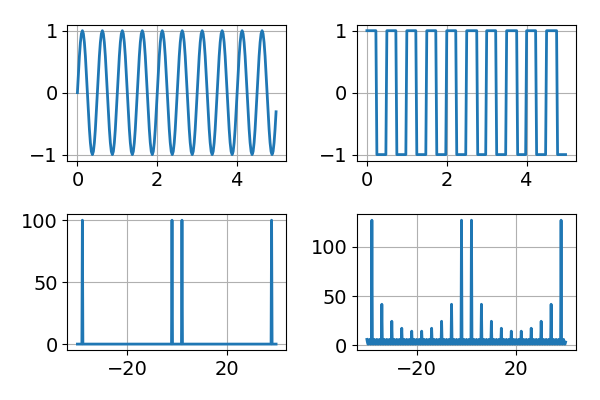

interactive(children=(SelectionSlider(continuous_update=False, description='f0', layout=Layout(height='20px', …

In [15]:
from scipy.signal import square
plt.close('all'); fig, ax = plt.subplots(2, 2, figsize=(6, 4))
t, dt = np.linspace(0, 5, num=200, endpoint=False, retstep=True); 
f = np.linspace(-1/dt, 1/dt, num=2*len(t), endpoint=False) 
tf = 2.0*np.pi*t[:, np.newaxis]*f[:,np.newaxis].T

def update(f0):
    for i, s in enumerate([np.sin(2.0*np.pi*f0*t), square(2.0*np.pi*f0*t)]):
        ax[0, i].cla(); ax[0, i].plot(t, s, linewidth=2);        
        S = np.dot(s, np.exp(-1j*tf)); 
        ax[1, i].cla(); ax[1, i].plot(f, np.absolute(S));
        ax[1, i].set_xticks([-20, 20])
interact(update, f0=SelectionSlider_nice(options=[1, 2, 5, 10, 19.99, 30]));

***
[Volver al índice](#index)

<a id="section4"></a>

# Efectos del muestreo  en la DFT

***

Muestrear es equivalente a multiplicar una señal continua por un tren de impulsos (peineta de Dirac)

$$
\text{III}_{T}(t) = \sum_{m=-\infty}^\infty \delta[t - m T],
$$
donde $T=\frac{1}{F_s}$. La transformada de Fourier del tren de impulsos (por demostrar) es
$$
\mathbb{FT}[\text{III}_T] =  2\pi F_s \sum_{m=-\infty}^\infty  \delta(\omega - 2\pi m F_s)
$$

Multiplicar en el tiempo corresponde a convolucionar en frecuencia

$$
\begin{align}
\mathbb{FT}[s(t) \text{III}(t)] &= \mathbb{FT}[s(t)] * \mathbb{FT}[\text{III}_T(t)] \nonumber \\
&= S(\omega) * 2\pi F_s \sum_{m=-\infty}^\infty  \delta(\omega - 2\pi m F_s) \nonumber \\
&= 2\pi F_s \sum_{m = -\infty}^{\infty} S(\omega - 2 \pi m F_s) \nonumber
\end{align}
$$
- 

<img src="img/fft-sampling1.png">
<img src="img/fft-sampling2.png">

<IPython.core.display.Javascript object>


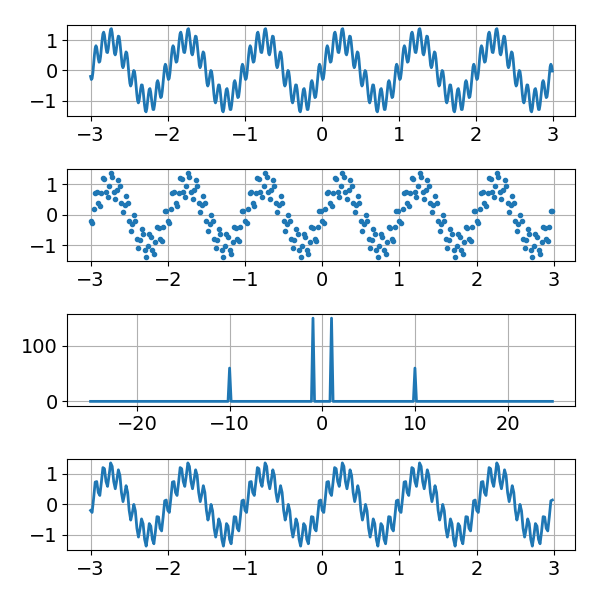

interactive(children=(SelectionSlider(continuous_update=False, description='Fs', index=4, layout=Layout(height…

In [16]:
fig, ax = plt.subplots(4, figsize=(6, 6));
def update(Fs):
    t = np.arange(-3, 3, step=0.01); N = len(t)
    s =  0.4*np.cos(2.0*np.pi*10*t + 2.0*np.pi/3) + np.sin(2*np.pi*t)
    ax[0].cla(); ax[0].plot(t, s, '-'); 
    ax[1].cla(); ax[1].plot(t[::int(100/Fs)], s[::int(100/Fs)], '.'); 
    S = fftpack.fft(s[::int(100/Fs)]); f=fftpack.fftfreq(n=len(S), d=1.0/Fs); 
    ax[2].cla(); ax[2].plot(np.sort(f), fftpack.fftshift(np.absolute(S)), linewidth=2);
    ax[3].cla(); ax[3].plot(t[::int(100/Fs)], fftpack.ifft(S), linewidth=2)
    #ax.set_xlabel("Time [s]"); 
interact(update, Fs=SelectionSlider_nice(options=[10, 15, 20, 35, 50], value=50));

***
[Volver al índice](#index)

<a id="section6"></a>

# Transformada Rápida de Fourier (FFT)

***

- La computación de la DFT tiene complejidad $\mathcal{O}(N^2)$
- Existe una aproximación numérica con complejidad $\mathcal{O}(N\log N)$: la Fast Fourier Transform (FFT). 

El algoritmo de Cooley-Tukey obtiene una FFT recursiva que explota las simetrías en la DFT

$$
\begin{align}
S[k] &=  \sum_{n=0}^{N-1} s[n] W_N^{kn} \nonumber \\
&= \sum_{n=0}^{N/2-1} s[2n] W_N^{k 2n} + \sum_{n=0}^{N/2-1} s[2n+1] W_N^{k(2n+1)} \nonumber \\
&= \sum_{n=0}^{N/2-1} s[2n] W_{N/2}^{kn} + W_N^{k} \sum_{n=0}^{N/2-1} s[2n+1] W_{N/2}^{kn} \nonumber \\
&= S_E[k] + W_N^{k} S_O[k] ~~ \forall k \in [0,N/2]  \nonumber 
\end{align} 
$$

Notar que se calculan dos "medias" DFT

## Transformada rápida de Fourier


Por periodicidad de la DFT tenemos que
$$
\begin{align}
S_E[k + N/2] &=  \sum_{n=0}^{N/2-1} s[2n] W_{N/2}^{(k+N/2)n} \nonumber \\
&=  \sum_{n=0}^{N/2-1} s[2n] W_{N/2}^{kn} \exp \left(-j2\pi n \right) = S_E[k], \nonumber
\end{align}
$$

e igualmente

$$
S_O[k + N/2] = S_O[k],
$$

juntando ambos tenemos que
$$
\begin{align}
S[k + N/2] &=  S_E[k + N/2] + W_{N}^{(k+N/2)} S_O[k + N/2] \nonumber  \\
&=  S_E[k] + W_{N}^{k} \exp \left(-j\pi\right) S_O[k] \nonumber \\
&=  S_E[k] - W_{N}^{k} S_O[k] \nonumber 
\end{align}
$$

es decir

$$
\begin{align}
S[k] &=  S_E[k] + W_{N}^{k} S_O[k] \nonumber \\
S[k + N/2] &=  S_E[k] - W_{N}^{k} S_O[k] \quad \forall k \in [0,N/2]  \nonumber 
\end{align}
$$

- La DFT de $k$ y $k+N/2$ difieren en un signo
- Se han explotado las simetrías de la DFT para reducir el costo computacional

<img src="img/fft-16samples.png">

Ref: http://www.themobilestudio.net/the-fourier-transform-part-14

Cantidad de multiplicaciones

| N | DFT | FFT | % |
|---|---|---|---|
| 32 | 1024 | 160 | 15.6 |
| 1,024 | 1,048,576 | 10,240 | 0.97 |

## Transformada rápida de Fourier

- Python: numpy.fft y scipy.fftpack
- C: The Fastest Fourier Transform in the WEst (FFTW)
- Para FFTW existen python wrappers

In [ ]:
help(fftpack.fft)

<IPython.core.display.Javascript object>


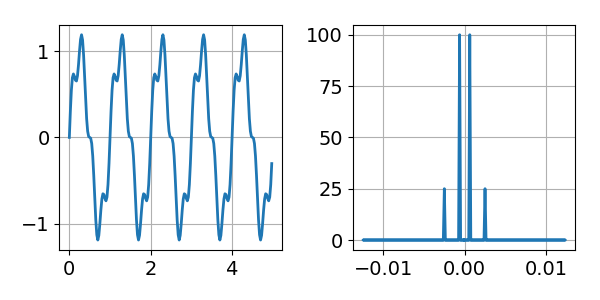

In [17]:
from scipy.signal import square
plt.close('all'); fig, ax = plt.subplots(1, 2, figsize=(6, 3))
t, dt = np.linspace(0, 5, num=200, endpoint=False, retstep=True); 
s = np.sin(2.0*np.pi*t) + 0.25*np.sin(2.0*np.pi*4*t)
ax[0].cla(); ax[0].plot(t, s, linewidth=2);        
f = fftpack.fftfreq(n=len(t), d=1/dt); S = fftpack.fft(s); 
ax[1].cla(); ax[1].plot(f, np.absolute(S));

In [18]:
from scipy import fftpack
t, dt = np.linspace(-10.0, 10.0, num=1000, retstep=True); s = np.sin(2.0*np.pi*t) 
freq = np.arange(-0.5/dt, 0.5/dt, step=1.0/20);
tf = 2.0*np.pi*t[:, np.newaxis]*freq[:, np.newaxis].T
print("DFT numpy")
%timeit -n 5 np.dot(s, np.exp(-1j*tf));
print("FFT fftpack")
%timeit -n 5 fftpack.fftshift(fftpack.fft(s))


DFT numpy
64.9 ms ± 4.09 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
FFT fftpack
The slowest run took 5.47 times longer than the fastest. This could mean that an intermediate result is being cached.
98.8 µs ± 63.8 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


### Ejemplo: Espectro de una señal sinusoidal con ruido blanco



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3));

def f(noise_level=0.0, frequency=2.0):
    t, dt = np.linspace(-10.0, 10.0, num=1000, retstep=True); 
    s = np.sin(2.0*np.pi*frequency*t) + noise_level*np.random.randn(len(t));
    ax[0].cla(); ax[1].cla(); ax[0].set_xlim([-5, 5]);
    ax[0].plot(t, s, linewidth=2); ax[0].set_xlabel("Time [s]");
    ax[1].set_xlabel("Frequency [Hz]");
    ax[1].plot(fftpack.fftfreq(n=len(t), d=1.0/dt), np.abs(fftpack.fft(s)), linewidth=2); 

interact(f, noise_level=FloatSlider_nice(min=0.0, max=6.0, description="Noise_level", layout=slider_layout),
            frequency=FloatSlider_nice(min=0.0, max=5.0, value=2, description="Signal frequency", layout=slider_layout));

***
[Volver al índice](#index)

<a id="section7"></a>

# Transformada de Fourier de tiempo reducido (STFT) y espectrograma

# Ejercicios 

1. Muestre que la transformada de Fourier de la convolución de los argumentos es la multiplicación de las FT de los argumentos

Vibrating strings: https://www.maths.ed.ac.uk/~jmf/Teaching/MT3/IntegralTransforms.pdf
- https://www.cl.cam.ac.uk/teaching/1213/MathMforCS/MathMforCSPartAslides.pdf
- http://www.robots.ox.ac.uk/~sjrob/Teaching/SP/l7.pdf
- http://greenteapress.com/thinkdsp/thinkdsp.pdf
- https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/
- https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html